# Imports

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [2]:
from EntropyCodec import *

## Helpers

In [3]:
def PSNR_RGB(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    mse = torch.mean(torch.square(y_pred - y_true))
    if mse == 0:
        return float('inf')  # consistent handling of zero MSE
    return (10 * torch.log10(max_pixel ** 2 / mse)).item()

# Data

In [4]:
class ImageDataset(Dataset):
    def __init__(self, foldername, transform=None):
        self.file_paths = [os.path.join(foldername, f) for f in os.listdir(foldername) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [127]:
test_path = './test/'
train_path = './train/'
batch_size = 1

train_dataset = ImageDataset(train_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modeling

## Debug Helpers 

In [178]:
def conv_out(h_in, kernel_size, padding, stride, dilation):
    h_out = (h_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    print(int(h_out))

def transpose_conv_out(h_in, kernel_size, padding, stride, dilation, output_padding):
    h_out = (
        (h_in - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    print(int(h_out))


In [69]:
conv_out(h_in=128, kernel_size=9, padding=5, stride=1, dilation=1)
conv_out(h_in=64, kernel_size=5, padding=2, stride=1, dilation=1)
conv_out(h_in=32, kernel_size=3, padding=1, stride=1, dilation=1)
print()
transpose_conv_out(16, kernel_size=3, padding=1, stride=2, dilation=1, output_padding=1)
transpose_conv_out(32, kernel_size=5, padding=2, stride=2, dilation=1, output_padding=1)
transpose_conv_out(64, kernel_size=7, padding=3, stride=2, dilation=1, output_padding=1)

128
64
32

32
64
128


## BaseModel

In [181]:
conv_out(h_in=128, kernel_size=9, padding=4, stride=1, dilation=1)

128


In [211]:
import torch
import torch.nn as nn

from src.modeling.base import BaseModel

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.gelu(self.conv1(x))
        out = self.conv2(out)
        out += residual
        return out

class ResAutoEncoder(BaseModel):
    def __init__(self, model_name='residual_ae'):
        super(ResAutoEncoder, self).__init__(model_name)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, padding=3, stride=2),
            nn.GELU(),
            ResidualBlock(128),
            nn.Conv2d(128, 32, kernel_size=5, padding=2, stride=2),
            nn.GELU(),
            ResidualBlock(32),
            nn.Conv2d(32, 16, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
        )

        self.decoder = nn.Sequential(
            ResidualBlock(16),
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            ResidualBlock(32),
            nn.ConvTranspose2d(
                32, 128, kernel_size=5, stride=2, padding=2, output_padding=1
            ),
            nn.GELU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(
                128, 3, kernel_size=7, stride=2, padding=3, output_padding=1
            ),
            nn.Sigmoid(),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, b_t=None):
        x = self.encoder(x)
        if self.training and b_t is not None:
            max_val = x.max() / (2 ** (b_t + 1))
            noise = torch.rand_like(x) * max_val
            x = x + noise
        x = self.decoder(x)
        return x

## Training

In [212]:
from torchvision.models import vgg16

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:23]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, reconstructed, original):
        loss = F.mse_loss(self.feature_extractor(reconstructed), self.feature_extractor(original))
        return loss


In [221]:
aux_loss = PerceptualLoss()

/Users/a.gorbatovskiy/miniconda/envs/codec/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/a.gorbatovskiy/miniconda/envs/codec/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [215]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResAutoEncoder()

In [219]:
pred = model(batch_sample)
aux_loss = aux_loss(pred, batch_sample)
aux_loss

tensor(1.5718, grad_fn=<MseLossBackward0>)

In [199]:
# Параметры изображений
w, h = 128, 128

epochs = 5

NumImagesToShow = 5
b = 3
bt = 3

In [217]:
sample = test_dataset[0]
batch_sample = next(iter(test_loader))

In [187]:
model(sample[None, :]).shape

torch.Size([1, 3, 128, 128])

In [85]:
model.eval()

BaseAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): GELU(approximate='none')
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): GELU(approximate='none')
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): GELU(approximate='none')
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv

In [52]:
def EntropyEncoder(enc_img, size_z, size_h, size_w):
    temp = enc_img.astype(np.uint8).copy()

    maxbinsize = size_h * size_w * size_z
    bitstream = np.zeros(maxbinsize, np.uint8)
    StreamSize = np.zeros(1, np.int32)
    HiddenLayersEncoder(temp, size_w, size_h, size_z, bitstream, StreamSize)
    return bitstream[: StreamSize[0]]


def EntropyDecoder(bitstream, size_z, size_h, size_w):
    decoded_data = np.zeros((size_z, size_h, size_w), np.uint8)
    FrameOffset = np.zeros(1, np.int32)
    HiddenLayersDecoder(decoded_data, size_w, size_h, size_z, bitstream, FrameOffset)
    return decoded_data

In [55]:
model(test_dataset[0]).shape

torch.Size([3, 128, 128])

In [61]:
test_dataset[0].shape

torch.Size([3, 128, 128])

In [65]:
np.max(test_dataset[0].numpy())

1.0

In [66]:
test_dataset[0].shape

torch.Size([3, 128, 128])

In [75]:
imgs_encoded = model.encoder(next(iter(test_loader)))

In [76]:
imgs_encoded.shape

torch.Size([21, 128, 16, 16])

In [81]:
imgs_encoded / imgs_encoded.amax(dim=(1, 2, 3), keepdim=True)

tensor([[[[0.0000, 0.0066, 0.0023,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0064, 0.0138,  ..., 0.0136, 0.0469, 0.0507],
          [0.0000, 0.0493, 0.0020,  ..., 0.0226, 0.0698, 0.0544],
          ...,
          [0.0000, 0.0576, 0.0288,  ..., 0.0381, 0.0767, 0.1002],
          [0.0304, 0.1058, 0.0707,  ..., 0.0718, 0.1065, 0.1157],
          [0.1562, 0.1025, 0.0749,  ..., 0.0829, 0.1365, 0.2062]],

         [[0.1258, 0.1609, 0.1812,  ..., 0.1521, 0.1597, 0.2972],
          [0.1738, 0.2634, 0.2798,  ..., 0.2090, 0.2570, 0.4064],
          [0.1862, 0.2763, 0.2291,  ..., 0.2628, 0.2564, 0.3652],
          ...,
          [0.2528, 0.3497, 0.3218,  ..., 0.3266, 0.3307, 0.4165],
          [0.2722, 0.3685, 0.3255,  ..., 0.3268, 0.3293, 0.4258],
          [0.4537, 0.4733, 0.4549,  ..., 0.4442, 0.4427, 0.5055]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [46]:
import os

def process_images(test_loader, model, device, b, w, h):
    imgs_encoded = []
    imgs_decoded = []

    with torch.no_grad():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            encoded_images = model.encoder(test_batch)
            decoded_images = model.decoder(encoded_images)

            imgs_encoded.append(encoded_images.cpu().detach())
            imgs_decoded.append(decoded_images.cpu().detach())

    imgs_encoded = torch.vstack(imgs_encoded)
    imgs_decoded = torch.vstack(imgs_decoded)


    max_encoded_imgs = imgs_encoded.amax(dim=(1, 2, 3), keepdim=True)
    # Normalize and quantize
    norm_imgs_encoded = imgs_encoded / max_encoded_imgs
    quantized_imgs_encoded = (torch.clip(norm_imgs_encoded, 0, 0.9999999) * pow(2, b)).to(
        torch.int32
    )
    quantized_imgs_encoded = quantized_imgs_encoded.numpy()

    # Encode and decode using entropy coding
    quantized_imgs_decoded = []
    bpp = []

    for i in range(quantized_imgs_encoded.shape[0]):
        size_z, size_h, size_w = quantized_imgs_encoded[i].shape
        encoded_bits = EntropyEncoder(quantized_imgs_encoded[i], size_z, size_h, size_w)
        
        byte_size = encoded_bits.nbytes
        bpp.append(byte_size * 8 / (w * h))
        quantized_imgs_decoded.append(EntropyDecoder(encoded_bits, size_z, size_h, size_w))
    quantized_imgs_decoded = torch.tensor(np.array(quantized_imgs_decoded, dtype=np.uint8))

    shift = 1.0 / pow(2, b + 1)
    dequantized_imgs_decoded = (quantized_imgs_decoded.to(torch.float32) / pow(2, b)) + shift
    dequantized_denorm_imgs_decoded = dequantized_imgs_decoded * max_encoded_imgs

    imgsQ_decoded = []

    with torch.no_grad():
        for deq_img in dequantized_denorm_imgs_decoded:
            deq_img = deq_img.to(device)
            decoded_imgQ = model.decoder(deq_img)

            imgsQ_decoded.append(decoded_imgQ.cpu().detach())

    imgsQ_decoded = torch.stack(imgsQ_decoded)

    assert imgsQ_decoded.shape == imgs_decoded.shape
    assert imgsQ_decoded.shape[0] == len(bpp)

    return imgs_decoded, imgsQ_decoded, bpp

In [47]:
imgs_decoded, imgsQ_decoded, bpp = process_images(test_loader, model, device, b, w, h)

In [43]:
import io

to_pil_transform = transforms.ToPILImage()

def JPEGRDSingleImage(torch_img, TargetBPP):
    image = to_pil_transform(torch_img)

    width, height = image.size
    realbpp = 0
    realpsnr = 0
    realQ = 0
    final_image = None

    for Q in range(101):
        img_bytes = io.BytesIO()
        image.save(img_bytes, "JPEG", quality=Q)
        img_bytes.seek(0)
        image_dec = Image.open(img_bytes)
        bytesize = len(img_bytes.getvalue())

        bpp = bytesize * 8 / (width * height)
        psnr = PSNR_RGB(np.array(image), np.array(image_dec))
        if abs(realbpp - TargetBPP) > abs(bpp - TargetBPP):
            realbpp = bpp
            realpsnr = psnr
            realQ = Q
            final_image = image_dec
            
    return final_image, realQ, realbpp, realpsnr

In [44]:
jpeg_img, JPEGQP, JPEGrealbpp, JPEGrealpsnr = JPEGRDSingleImage(test_dataset[0], 0.5)

In [25]:
def display_images_and_save_pdf(test_dataset, imgs_decoded, imgsQ_decoded, bpp, filepath, NumImagesToShow=None):
    if NumImagesToShow is None:
        NumImagesToShow = len(test_dataset)
    cols = NumImagesToShow
    rows = 4

    fig = plt.figure(figsize=(2 * cols, 2 * rows))

    for i in range(NumImagesToShow):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(to_pil_transform(test_dataset[i]), interpolation="nearest")
        plt.title("", fontsize=10)
        plt.axis('off')
    
    for i in range(NumImagesToShow):
        psnr = PSNR(test_dataset[i], imgs_decoded[i])
        plt.subplot(rows, cols, cols + i + 1)
        plt.imshow(to_pil_transform(imgs_decoded[i]), interpolation="nearest")
        plt.title(f"PSNR: {psnr:.2f}", fontsize=10)
        plt.axis('off')
    
    for i in range(NumImagesToShow):
        psnr = PSNR(test_dataset[i], imgsQ_decoded[i])
        plt.subplot(rows, cols, 2 * cols + i + 1)
        plt.imshow(to_pil_transform(imgsQ_decoded[i]), interpolation="nearest")
        plt.title(f"PSNR: {psnr:.2f} | BPP: {bpp[i]:.2f}", fontsize=10)
        plt.axis('off')
    

    for i in range(NumImagesToShow):
        jpeg_img, JPEGQP, JPEGrealbpp, JPEGrealpsnr = JPEGRDSingleImage(test_dataset[i], bpp[i])
        plt.subplot(rows, cols, 3 * cols + i + 1)
        plt.imshow(jpeg_img, interpolation="nearest")
        plt.title(f"PSNR: {JPEGrealpsnr:.2f} | BPP: {JPEGrealbpp:.2f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(filepath, format='pdf')
    return fig

955
49152
955
49152
956
49152
978
49152
1024
49152
1074
49152
1118
49152
1169
49152
1220
49152
1280
49152
1323
49152
1362
49152
1405
49152
1450
49152
1492
49152
1529
49152
1575
49152
1608
49152
1642
49152
1677
49152
1717
49152
1756
49152
1795
49152
1833
49152
1859
49152
1892
49152
1925
49152
1955
49152
1987
49152
2015
49152
2047
49152
2078
49152
2104
49152
2140
49152
2163
49152
2203
49152
2244
49152
2259
49152
2294
49152
2317
49152
2330
49152
2377
49152
2395
49152
2426
49152
2459
49152
2481
49152
2513
49152
2533
49152
2560
49152
2599
49152
2611
49152
2622
49152
2674
49152
2709
49152
2728
49152
2758
49152
2799
49152
2830
49152
2870
49152
2895
49152
2933
49152
2984
49152
3018
49152
3063
49152
3096
49152
3153
49152
3189
49152
3218
49152
3272
49152
3320
49152
3394
49152
3449
49152
3494
49152
3555
49152
3660
49152
3682
49152
3768
49152
3881
49152
3980
49152
4049
49152
4151
49152
4271
49152
4369
49152
4520
49152
4633
49152
4781
49152
4987
49152
5144
49152
5382
49152
5580
49152
5916
49152
616

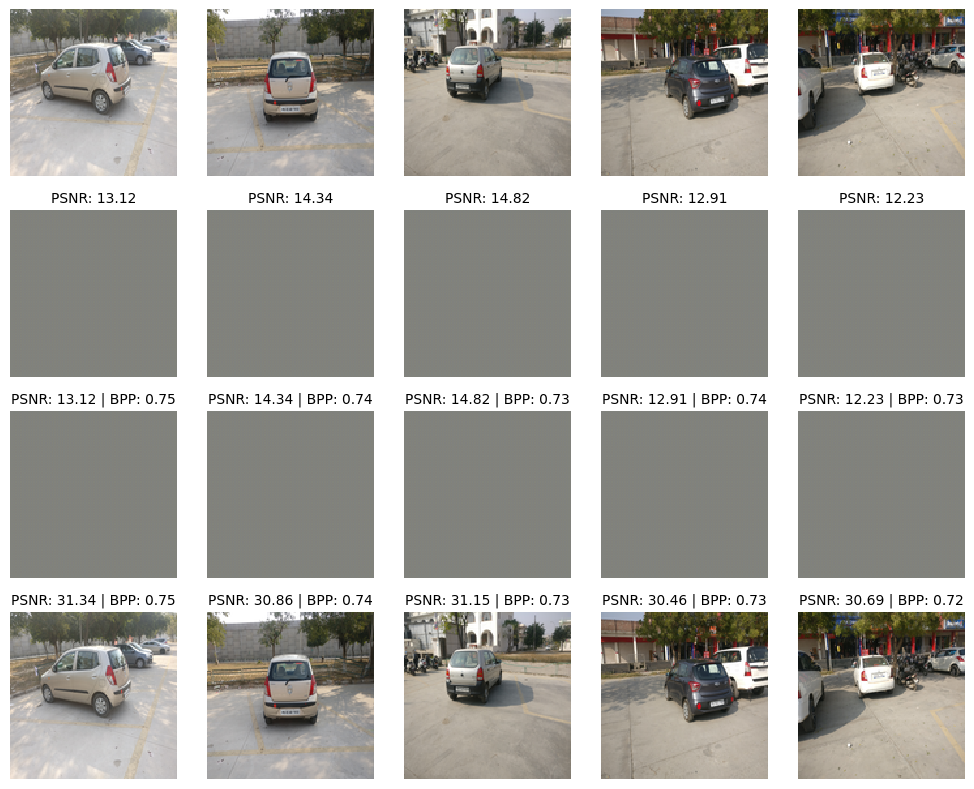

In [23]:
fig = display_images_and_save_pdf(test_dataset, imgs_decoded, imgsQ_decoded, bpp, 'output.pdf', NumImagesToShow=5)

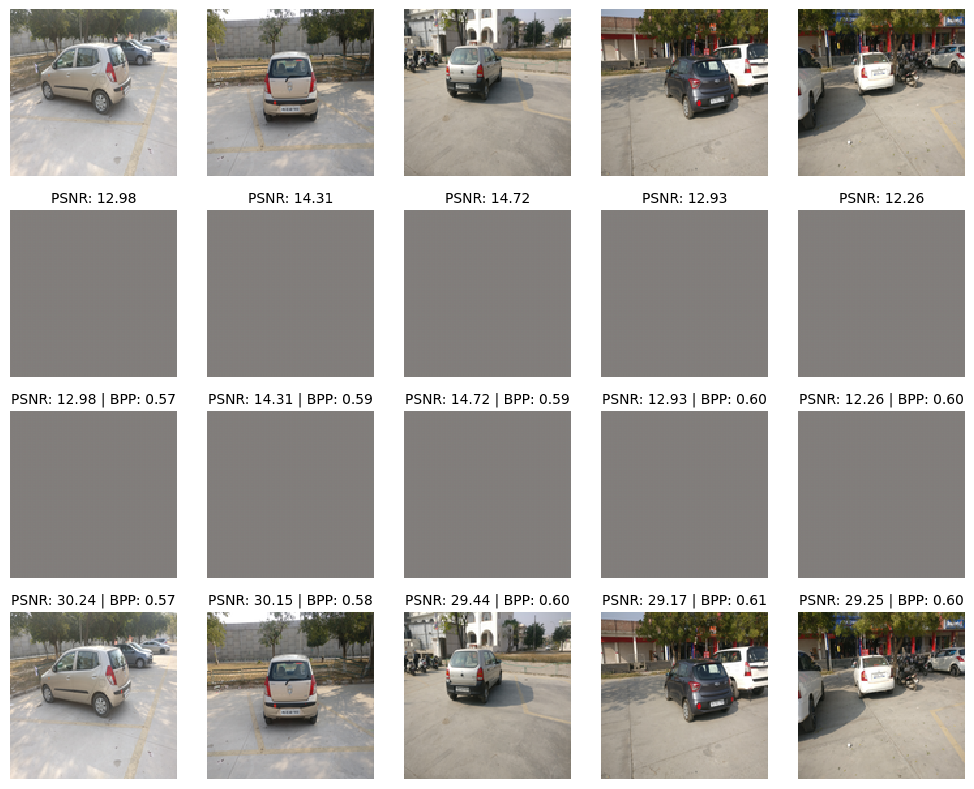

In [408]:
fig